# RAMSES Fundamentals

## 1. Prerequisites

You will need a `fortran compiler` to compile RAMSES, along with some version of `MPI` if you have access to multiple cores and want to run RAMSES in parallel. You can refer to the [Instructions to get started on the CBP machine](https://ramses-tutorials.readthedocs.io/en/latest/Setup/CBP.html) or [Instructions to get started on your laptop](https://ramses-tutorials.readthedocs.io/en/latest/Setup/laptop.html) sections for some information about how to install or load those, according to your needs.

The tutorials require running `python3` in a `Jupyter notebook`, and will use different python packages and analysis tools (see the prerequisites section of each tutorial). For simplicity, we recommend [setting up a complete environment with conda](https://ramses-tutorials.readthedocs.io/en/latest/Setup/conda-setup.html).

## 2. First steps with RAMSES

RAMSES [(Teyssier 2002)](https://ui.adsabs.harvard.edu/abs/2002A%26A...385..337T/abstract) is a popular code used to produce astrophysical simulations, using the adaptive mesh refinement (AMR) numerical technique, together with state-of-the art star formation and feedback models. Each directory contains a set of files with a given common purpose. For example, amr/ contains all Fortran 90 routines dealing with the AMR grid management and MPI communications, while hydro/ contains all Fortran 90 routines dealing with hydrodynamics. RAMSES is written in Fortran 90, which can be used on massively parallel architectures thanks to the MPI library (MPI stands for Message Passing Interface). Therefore, before producing RAMSES simulations, we need to compile the RAMSES code, as explained below.

In order to **obtain and compile the code**, you can follow the first steps of the documentation at [this link](https://ramses-organisation.readthedocs.io/en/latest/wiki/Start.html), summarised (and updated) below.

### 2.1 Downloading the code

To get the RAMSES code, open a terminal, and clone the code into the Fundamentals sub-directory:


In [ ]:
%%bash
git clone https://github.com/ramses-organisation/ramses



### 2.2 Compiling the code: the Makefile

The first directory you are interested in is the bin/ directory, in which the code will be compiled thanks to the set of instructions written in the `Makefile`.


In [ ]:
%%bash
cd ramses/bin
cat Makefile



The first lines of the Makefile correspond to the so-called *Compilation Time Parameters*. They are used to e.g.:

- set the type of compiler to be used, the name of the RAMSES executable

- define the number of dimensions and the total number of variables needed for the simulation

- enable or disable the compilation of some of the physical modules, and of the MPI routines 

Other preprocessor directives are then defined below, in the variable `DEFINES`.

Based on the choice of compiler (`COMPILER=GNU` or `INTEL`), Fortran compiler options and directives are defined. The `F90` variable invokes the Fortran compiler (also depends on the use of MPI), while `FFLAGS` contains other compilation flags and preprocessor directives (also depends on the use of debug options). While both `F90` and `FFLAGS` can be set up using default values, one might need or want to edit them according to the compiler, the machine, or the simulation. In this case, you can manually edit `F90` and `FFLAGS` in the Makefile.

Finally, the rest of the Makefile contains the list and path of the files to be compiled.

Once the Makefile is ready, you can (re)compile the code:


In [ ]:
%%bash
cd ramses/bin
make clean
make


### 2.3 Setting up the parameters: the namelist

To run a simulation, RAMSES needs a parameter file, which is a *Fortran namelist* ([brief intro here](http://jules-lsm.github.io/vn4.2/namelists/intro.html), and more details about the [RAMSES namelist here](https://ramses-organisation.readthedocs.io/en/latest/wiki/Runtime_Parameters.html)). Namelists can be read and written as text files, usually ending with `.nml`. They are used to assign values to RAMSES variables, to be used instead of the default values initialised in the code.

Namelist files are organised in namelist blocks, or sections (that may be provided in any order) that define parameters related to different parts of the code. Each block starts with `&BLOCK_NAME` and ends with the character `/`. Values are then declared in the corresponding block using standard Fortran namelist syntax, i.e. as `parameter_name = value` (where values for character variables must be enclosed in quotes, and logical values must be specified using `.true.` or `.false.`). The following 4 parameter blocks are mandatory and must always be present in the namelist file:


1. `RUN_PARAMS`: defines some of the most basic properties of the run

2. `AMR_PARAMS`: defines the global mesh properties and memory footprint of the code

3. `INIT_PARAMS`: tells RAMSES where to look for initial condition files

4. `OUTPUT_PARAMS`: defines the output strategy

The other blocks are optional. They must be present in the file only if they are relevant to the current run:


5. `POISSON_PARAMS`: specifies runtime parameters for the Poisson solver

6. `BOUNDARY_PARAMS`: sets up boundary conditions for the current simulation

7. `UNIT_PARAMS`: contains the parameters related to units that are set “by hand” for non cosmological runs

8. `COOLING_PARAMS`: contains parameters related to cooling / basic chemistry

9. `SF_PARAMS`: contains the parameters related to star formation

10. `FEEDBACK_PARAMS`: contains the parameters related to stellar feedback

11. `HYDRO_PARAMS`: specifies runtime parameters for the Godunov solver

12. `REFINE_PARAMS`: defines the refinement strategy

13. `SINK_PARAMS`: contains the parameters related to the sink particle implementation, for star formation or black holes

14. `CLUMPFIND_PARAMS`: contains the parameters related to the built-in RAMSES clump finder (PHEW)

15. `RT_PARAMS` and `RT_GROUPS`: sets radiative properties for RAMSES RHD runs

16. `MOVIE_PARAMS`: contains the parameters related to the movies, for creating on the fly visualizations of a simulation

The variables you can set or adjust in each namelist block are described in more details in the the [RAMSES namelist documentation](https://ramses-organisation.readthedocs.io/en/latest/wiki/Runtime_Parameters.html) and in the different tutorials.

## 3. Barotrop test

This 1-dimensional RAMSES test of a gas gravitational collapse is part of the automated RAMSES test suite. First compile a 1d RAMSES executable:


In [ ]:
%%bash
cd ramses/bin
make clean
make NDIM=1 PATCH= SOLVER=hydro EXEC=ramses_barotrop


Then run the test, using the bartrop.nml namelist:


In [ ]:
%%bash
cd barotrop
../ramses/bin/ramses_barotrop1d barotrop.nml



You should see RAMSES start and spit out a log of its progress in the terminal. Once it is finished (this should be less than a second), you'll see two output directories, named output_00001 and output_00002.

After the run is done, you can use the cell below to plot the final result and compare to an analytic solution for the temperature versus density.

Processing 1 files in ./barotrop/output_00002
Loaded: 784 cells, 0 particles.


(1, 16106.507495436626)

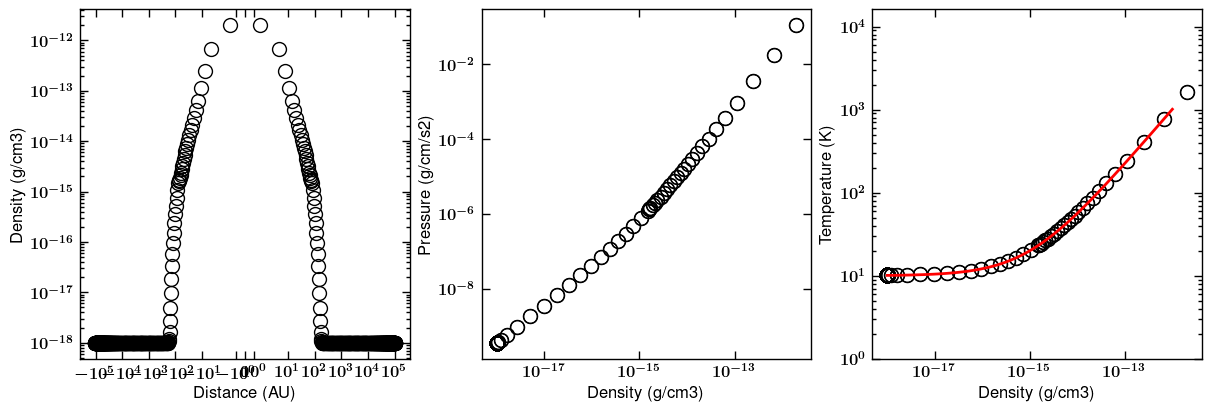

In [62]:
import osyris
import numpy as np
import matplotlib.pyplot as plt

# Fundamental constants
MH = 1.6737236e-24 #g                      # hydrogen mass
KB = 1.38064852e-16 #cm^2 g s^-2 K^-1      # Boltzman constant
PC = 3.0857e18 #cm                         # 1 parsec
AU = 1.49597871e13 #cm                     # 1 astronomical unit

# Load RAMSES output
data = osyris.Dataset(2, path="./barotrop/")
data.load()

center = osyris.Array(values=[3.0857e18/2.], unit='cm')

x      = (data["amr"]["position_x"]-center).to("au").values
rho    = data["hydro"]["density"].values
p      = data["hydro"]["pressure"].values


# We can also plot directly with Osyris, but here we use our own plots for more flexibility
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), constrained_layout=True)

ax[0].plot(x,rho,'o',color='black',markerfacecolor='none')
ax[0].set_xlabel('Distance (AU)')
ax[0].set_ylabel('Density (g/cm3)')
ax[0].set_xscale('symlog', linthresh=1.*PC/AU/2**16)
ax[0].set_yscale('log')

ax[1].plot(rho,p,'o',color='black',markerfacecolor='none')
ax[1].set_xlabel('Density (g/cm3)')
ax[1].set_ylabel('Pressure (g/cm/s2)')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

cs = np.sqrt(p/rho)
cs2 = p/rho
T = cs2 * 2.37 * MH /KB

#analytical solution
rho_ana = np.logspace(-18,-12,50)
b3 = 10 * (1 + (rho_ana/1e-15)**(1.666667-1))

ax[2].plot(rho,T,'o',color='black',markerfacecolor='none')
ax[2].plot(rho_ana, b3, color='red')

ax[2].set_xlabel('Density (g/cm3)')
ax[2].set_ylabel('Temperature (K)')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_ylim(1,max(T)*10)

## 4. A Sedov-Taylor blast in 3D

We now turn to 3d experiments, starting with a very simple setup of a thermal blast in a homogeneous medium.
First compile a 3d version of the code, using MPI:


In [ ]:
%%bash
cd ramses/bin
make clean
make NDIM=3 PATCH= SOLVER=hydro MPI=1 EXEC=ramses_sedov

Then run the test on four cores, using the sedov3d.nml namelist:


In [ ]:
%%bash
cd sedov
mpirun -n 4 ../ramses/bin/ramses_sedov3d sedov3d.nml


After the run is done, or even while it is running, you can use the cell below to plot the final result and compare to an analytic solution for the temperature versus density. 

For this experiment setup, i.e. an initially homogeneous environment and no radiative cooling, an analytic solution exists for the evolution of the blast profile. The cell just below computes this analytic profile and needs to be run only once to compare to the RAMSES run.

In [41]:
# This cell contains a routine to plot analytic Sedov profiles in N dimensions. 
# Just run the cell to compile it and then go to the cell below to use the routine.

##########################################################################
#       The routine returns 4 arrays of unknown size (determined
#       automatically by the routine). The output variables are
#       the following dimensionless quantities: r (position from the
#       point like explosion, d (density), u (velocity) and p
#       (pressure). To recover the true value, you have to rescale
#       these dimensionless values to the true values, defining first
#       the total energy E_0, the initial mass density rho_0 and the
#       time t you consider and finally computing the true values
#       using  the following scaling laws:
#
#       r = r * (E_0/rho_0)^(1./(dim+2.)) * t^(2./(dim+2.))
#       d = d * rho_0
#       u = u * (E_0/rho_0)^(1./(dim+2.)) * t^(-dim/(dim+2.))
#       p = p * (E_0/rho_0)^(2./(dim+2.)) * t^(-2.*dim/(dim+2.)) * rho_0
#
# This routine is adapted from an IDL routine by R Teyssier
def sedovana(gamma=1.4,dim=1):
    import numpy as np
    #---------------------------------------------------------------------
    n = int(dim)
    print('gamma=',gamma)
    g=float(gamma)
    n=float(n)
    n1=1000 ; n2=1000
    vmax=4.e0/(n+2.)/(g+1.)
    vmin=2.e0/(n+2.)/g
    temp = np.linspace(0,n1-1,n1)
    v=vmin+10.e0**(-10.e0*(1.0e0-(temp+1)/float(n1)))*(vmax-vmin)
    a2 = (1.-g)/(2.*(g-1.)+n)
    a1 = (n+2.)*g/(2.+n*(g-1.)) * ( 2.*n*(2.-g)/g/(n+2.)**2 - a2 )
    a3 = n/(2.*(g-1)+n)
    a4 = a1*(n+2.)/(2.-g)
    a5 = 2./(g-2.)
    a6 = g/(2.*(g-1.)+n)
    a7 = a1*(2.+n*(g-1.))/(n*(2.-g))

    r1 = ((n+2.)*(g+1.)/4.*v)**(-2./(2.+n)) \
          *((g+1.)/(g-1.) *( (n+2.)*g/2.*v-1.) )**(-a2) \
          *( (n+2.)*(g+1.) / ( (n+2)*(g+1)-2.*(2.+n*(g-1.)) ) * (1.-(2.+n*(g-1.))/2.*v) )**(-a1)      
    u1 = (n+2.)*(g+1.)/4.*v*r1
    d1 = ((g+1.)/(g-1.)*((n+2.)*g/2.*v-1.))**(a3)   \
         *((g+1.)/(g-1.)*(1.-(n+2.)/2.*v  ))**(a5)  \
         *((n+2.)*(g+1.)/( (n+2)*(g+1)-2.*(2.+n*(g-1.))) *(1.-(2.+n*(g-1.))/2.*v) )**(a4)
    p1 = ((n+2.)*(g+1.)/4.*v)**(2.*n/(2.+n))        \
      *((g+1.)/(g-1.)*(1.-(n+2.)/2.*v  ))**(a5+1.)  \
      *((n+2.)*(g+1.)/( (n+2)*(g+1)-2.*(2.+n*(g-1.))) *(1.-(2.+n*(g-1.))/2.*v) )**(a4-2.*a1)

    temp=np.linspace(0,n2-1,n2)
    r2=r1[0]*(temp+0.5e0)/float(n2)
    u2=u1[0]*r2/r1[0]
    d2=d1[0]*(r2/r1[0])**(n/(g-1.0e0))
    p2=p1[0]*(r2/r2)
    r=np.zeros(len(r1)+len(r2)+2)
    r[0:len(r2)]=r2
    r[len(r2):len(r1)+len(r2)]=r1
    r[len(r1)+len(r2)]=r1.max()
    r[len(r1)+len(r2)+1]=r1.max()+1000.
    d=np.zeros(len(r))
    d[:]=r[:]
    d[0:len(r2)]=d2
    d[len(r2):len(r1)+len(r2)]=d1
    d[len(r1)+len(r2)]=1./((g+1.)/(g-1.))
    d[len(r1)+len(r2)+1]=1./((g+1.)/(g-1.))
    u=np.zeros(len(r))
    u[:]=r[:]
    u[0:len(r2)]=u2
    u[len(r2):len(r1)+len(r2)]=u1
    u[len(r1)+len(r2)]=0.
    u[len(r1)+len(r2)+1]=0.
    p=np.zeros(len(r))
    p[:]=r[:]
    p[0:len(r2)]=p2
    p[len(r2):len(r1)+len(r2)]=p1
    p[len(r1)+len(r2)]=0.
    p[len(r1)+len(r2)+1]=0.

    d=d*(g+1.)/(g-1.)
    u=u*4./(n+2.)/(g+1.)
    p=p*8./(n+2.)**2./(g+1.)

    nn=len(r)
    vol=np.zeros(nn)
    vol[:]=r[:]
    for i in range(1,nn):
        vol[i]=r[i]**n-r[i-1]**n
    vol[0]=r[0]**n
    const=1.
    if n == 1.: const=2.0e0
    if n == 2.: const=3.1415926535897931
    if n == 3.: const=4.*3.1415926535897931/3.

    vol=vol*const
    int1=(d*u*u/2.e0)*vol
    int2=p/(g-1.e0)*vol
    sum1=sum(int1)
    sum2=sum(int2)
    summ=sum1+sum2
    print('chi0=',summ**(-1./(2.+n)))
    chi0=summ**(-1./(2.+n))
    r=r*chi0
    u=u*chi0
    p=p*chi0**2

    return r,d,u,p


Now make a map of the simulated Sedov explosion, using the Osyris package:

Processing 1 files in ./sedov/output_00010
Loaded: 345976 cells, 0 particles.
Dataset: ./sedov/output_00010: 30.45 MB
Datagroup: amr 13.84 MB
'level' Min: 6 Max: 7 [] (345976,)
'cpu' Min: 1 Max: 1 [] (345976,)
'dx' Min: 2.411e+19 Max: 4.821e+19 [cm] (345976,)
'position' Min: 4.175e+19 Max: 5.303e+21 [cm] (345976,), {x,y,z}

Datagroup: hydro 16.61 MB
'density' Min: 1.329e-26 Max: 3.265e-25 [g / cm ** 3] (345976,)
'pressure' Min: 1.381e-17 Max: 9.599e-13 [erg / cm ** 3] (345976,)
'velocity' Min: 0.0 Max: 2.484e+06 [cm / s] (345976,), {x,y,z}
'mass' Min: 0.122 Max: 9.354 [M_sun] (345976,)

Datagroup: part 0B
'mass' Value: [] [g] (0,)
'identity' Value: [] [] (0,)
'levelp' Value: [] [] (0,)
'family' Value: [] [] (0,)
'tag' Value: [] [] (0,)
'position' Value: [], [], [] [cm] (0,), {x,y,z}
'velocity' Value: [], [], [] [cm / s] (0,), {x,y,z}


The total energy is 8.311e+50 [erg]


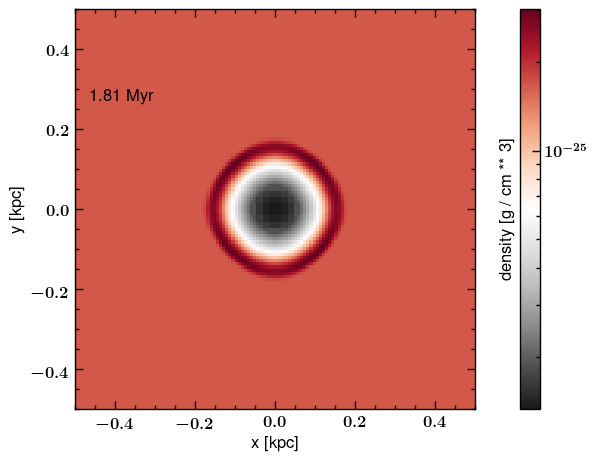

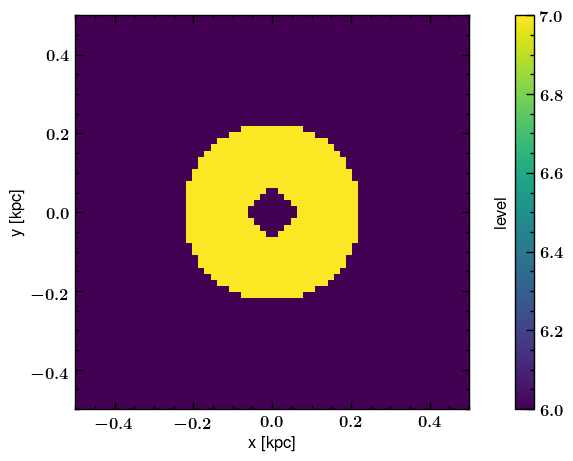

In [42]:
import osyris
import matplotlib.pyplot as plt
import numpy as np

snap=10 # You can change this!
mydata = osyris.Dataset(snap, path="./sedov/").load()
print(mydata)
kpc = osyris.units("kpc")
center=osyris.Vector(0.5,y=0.5,z=0.5,unit=kpc)
# Map of density and refinement level
osyris.map({"data": mydata["hydro"]["density"], "cmap":"RdGy_r", "norm":"log"}
           ,dx=1*kpc,origin=center)
time_myr = mydata.meta["time"].to("Myr").magnitude
time_sec = mydata.meta["time"].to("sec").magnitude
plt.annotate('%.2f Myr'%(time_myr), xy=(0.15, 0.8),xycoords='figure fraction')

egy_tot = np.sum(mydata['hydro']['pressure']*mydata['amr']['dx']**3)/0.4
print('The total energy is %.3e %s'%(egy_tot.values, egy_tot.label))

# Map of refinement level
osyris.map({"data": mydata["amr"]["level"], "cmap":"viridis"}
           ,dx=1*kpc,origin=center)

gamma= 1.4
chi0= 1.030904745855628


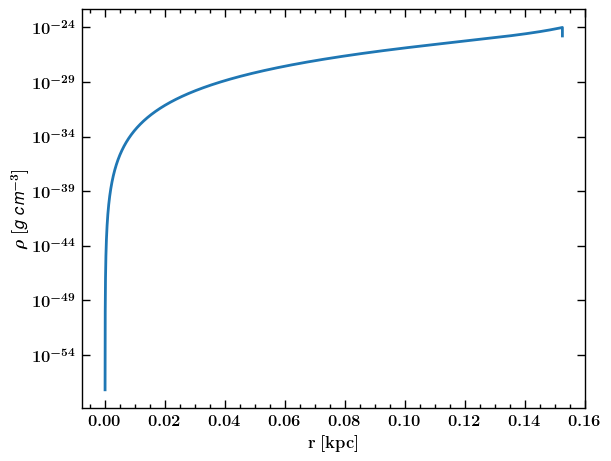

In [43]:
# Compute analytic profile corresponding to the simulation time, time_sec
import matplotlib.pyplot as plt
dim=3.
r,d,u,p=sedovana(dim=dim)
n = len(r)
r=r[0:n-1]
d=d[0:n-1]
u=u[0:n-1]
p=p[0:n-1]
E_0=1e51
rho_0 = 0.1 * 1.66e-24
r_cgs = r * (E_0/rho_0)**(1./(dim+2.)) * time_sec**(2./(dim+2.))
d_cgs = d * rho_0
u_cgs = u * (E_0/rho_0)**(1./(dim+2.)) * time_sec**(-dim/(dim+2.))
p_cgs = p * (E_0/rho_0)**(2./(dim+2.)) * time_sec**(-2.*dim/(dim+2.)) * rho_0
plt.figure()
plt.yscale('log')
plt.xlabel(r'${\rm r \ [kpc]}$')
plt.ylabel(r'${\rho \ [g \ cm^{-3}]}$')
plt.plot(r_cgs/3.08e21,d_cgs)
plt.show() 

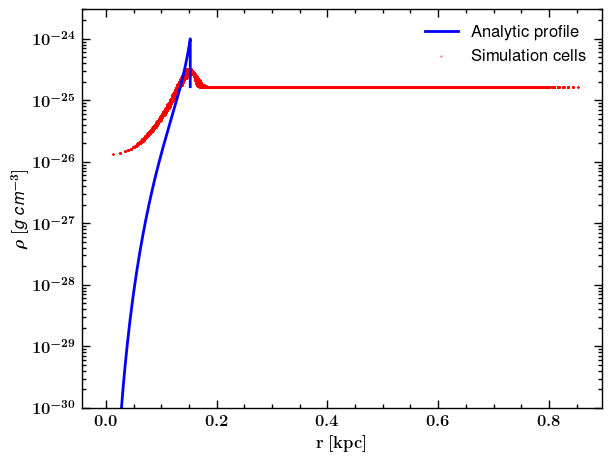

In [44]:
# Compare analytic and simulation profiles
import matplotlib.pyplot as plt
plt.figure()
plt.yscale('log')
plt.xlabel(r'${\rm r \ [kpc]}$')
plt.ylabel(r'${\rho \ [g \ cm^{-3}]}$')
plt.ylim(1e-30,3e-24)

plt.plot(r_cgs/3.08e21,d_cgs, color='blue', label='Analytic profile')

rad = (mydata["amr"]["position"] - center).to("kpc").norm.values
plt.scatter(rad, mydata['hydro']['density'].values,s=0.1, color='red', label='Simulation cells')

plt.legend()
plt.show()

You can now try to change the two cells above to compare the simulated pressure and velocity to the analytic solution (instead of density).

Generally, the comparison you should see is OK in terms of the position of the expanding shock blast, but the simulated profile does not really fit the analytic solution perfectly. What do you think are the reasons for that and what could be done in the simulation to improve
the comparison?

### 4.1 Diverging from the analytic solution

In reality, even the position of the blast in the Sedov-Taylor solution is not a very accurate description of the late evolution of SN blasts. In part this is because the environment is usually far from being homogeneous, but perhaps more importantly there is the effect of radiative cooling.

Try to run a new Sedov-Taylor blast experiment where you turn on radiative cooling in the namelist. What happens to your blast and how does it now compare to the analytic solution?

You can then try to change to Solar metallicity by setting `z_ave = 1` in the namelist, i.e. assume a Solar metallicity for all gas. What happens now and why?

### 4.2 Code units (optional)

This exercise is for understanding how to convert between the RAMSES code units and physical units. The exercise is optional but probably very useful, since if you go on to seriously use RAMSES, you’ll find that a large part of your time, frustration, and confusion will be due
to unit conversions.

To convert from energy, $E = 10^{51}$ ergs, to the `p_region` value in the namelist for the Sedov blast, you need first to keep in mind the equation of state, i.e.
$$ p = e (\gamma - 1), $$
where $e$ is energy density, $p$ is pressure, and $\gamma= 1.4$ is the ratio of specific heats, also given in the namelist. You also need to convert the energy to code units. In RAMSES this is achieved with the three base units, which are also given in the namelist. Each of these converts a RAMSES variable, in code units, to cgs units. In other words, you multiply a density given by RAMSES, with `units_density` to convert to $\rm{ g /cm^3}$, you multiply a length in RAMSES with `units_length` to convert to $\rm cm$ and a time with `units_time` to convert to seconds. For example, you can find that the box length of 1 given in code units in the namelist corresponds to 1 kpc and that the initial homogeneous density given by `d_region` corresponds to $1.66 \times 10^{−25} \ {\rm g / cm^3}$. Any unit conversion can be derived from these three basic units. For example, speed is converted from code units to $\rm cm/s$ with
$$ \rm units\_v = units\_length \times units\_time $$

I now leave it to you to see if you can derive how the value of ${\rm p\_region}= 8.6 \times 10^{−7}$ in the Sedov namelist corresponds to $10^{51}$ ergs.

You can now play with the Sedov blast run if you like, e.g. change the resolution, refinement strategy, or the hydro solver. You can also experiment with running the same experiment in 1d or 2d (for which you can also compare to analytic solutions).

## 5. A Strömgren _circle_ in 2D

Now we go for a bit of radiative transfer (RT) and radiation hydrodynamics (RHD), using the M1 RT method in RAMSES-RT. 

The Strömgren sphere is one of the few radiative transfer tests which has a simple analytic result to compare to. In two dimensions, in the limit of a constant radiation source emitting $\dot N$ photons per second into a stationary and homogeneous pure hydrogen gas with number density $\rm n_H$, a so-called Strömgren circle (sphere in 3d) of ionised hydrogen (HII) forms, initially expands, and eventually settles at the Strömgren radius, $r_S$, where the rate of recombinations inside the circle equals the source luminosity, i.e.
$$
\dot N = \pi r_{\rm S}^2 n_{\rm H}^2 \alpha^{\rm B}
$$
where $\alpha^{\rm B}$ is the case-B recombination rate of the gas. Solving for the 2d Strömgren radius, we get
$$
r_{\rm S} = \sqrt{\frac{\dot N}{\pi n_{\rm H}^2 \alpha^{\rm B}}}.
$$

The propagation of the ionization front (I-front) with time t can easily be derived to have the form
$$
r_{\rm I}(t) = r_{\rm S} \sqrt{1-e^{-t/t_{\rm rec}}},
$$
where $t_{\rm rec} = \left( n_{\rm H} \alpha^{\rm B} \right)^{−1}$ is the recombination time of the gas. 
(Pawlik & Schaye 2008,  showed that the analytic expression above for $r_{\rm S}$ is actually too small by 5%, due to the approximation of a step function in the ionised fraction at the Strömgren radius.)

### 5.1 Compare to the analytic Strömgren radius, with a reduced light speed
First, compile RAMSES-RT:


In [ ]:
%%bash
cd ramses/bin
make clean
make NDIM=2 SOLVER=hydro RT=1 NGROUPS=3 NIONS=3 NMETALS=1 EXEC=ramses_rhd


Then run the Strömgren circle experiment:


In [ ]:
%%bash
cd stromgren
../ramses/bin/ramses_rhd2d stromgren2d.nml



The namelist (stromgren2d.nml) sets up an isotropic source of radiation, with a luminosity of $\dot N = 2 \times 10^{28}$
ionizing photons per second, in the corner of a 1 kpc wide cubic box. The homogeneous gas density is set to $n_{\rm H} = 10^{−1} \ {\rm cm}^{−2}$. In the namelist, the `rt_TConst=1d4` parameter forces the temperature everywhere to $10^4$ K, which sets a constant recombination rate $\alpha^{\rm B} = 2.6 \times 10^{-13} \ \rm s^{−1} \rm cm^{2}$. From the equation above, we then get $r_{\rm S} = 0.51$ kpc, the recombination time is $t_{\rm rec} = 1.2$ Myr, and the Strömgren circle crossing time is $t_{\rm cross} ≡ r_{\rm S}/c = 1650$ years.

Now use the cell below to plot the results and compare the ionization front (or I-front) to the analytic expressions for $r_{\rm S}$ and $r_{\rm I}$, shown in red and yellow quarter-circles respectively. The I-front should converge towards the red circle and should do so following the time-evolution of the yellow quarter-circle.

In [61]:
import osyris
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interactive
kb = 1.3807e-16 # Boltzmann constant in cgs
mp = 1.6749e-24 # Proton mass in grams

def show_stromgren_maps(snapshot=1):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 7), constrained_layout=False)
    mydata = osyris.Dataset(snapshot, path="./stromgren").load()
    kpc = osyris.units("kpc")
    center=osyris.Vector(0.5,y=0.5,unit=kpc)

    # Map of gas density
    osyris.map(mydata["hydro"]["density"], cmap="viridis", norm="log", vmin=1e-2, vmax=1e0
           ,dx=1*kpc,origin=center,ax=ax[0][0])
    # Map of hydrogen ionization fraction
    mydata["hydro"]["scalar_00"].name = r'${\rm x_{HII}}$'
    osyris.map(mydata["hydro"]["scalar_00"], cmap="summer", norm="log", vmin=1e-4, vmax=1e0
           ,dx=1*kpc,origin=center,ax=ax[1][0])
    # Map of temperature
    mydata["hydro"]["T"] = mydata["hydro"]["pressure"]/mydata["hydro"]["density"] * mp/kb # Create new var for temperature
    mydata["hydro"]["T"].name = r'${\rm T/\mu \ [K]}$'
    mydata["hydro"]["T"].unit = ''
    osyris.map(mydata["hydro"]["T"], cmap="coolwarm", norm="log", vmin=3e3, vmax=3e5
           ,dx=1*kpc,origin=center,ax=ax[0][1])
    # Map of photon flux
    mydata["rt"]["photon_flux_01"] = mydata["rt"]["photon_flux_01"]*mydata.meta["unit_l"]/mydata.meta["unit_t"]
    mydata["rt"]["photon_flux_01"].name = r'${\rm cN_{\gamma} \ [cm^{-1} \ s^{-1}]}$'
    osyris.map(mydata["rt"]["photon_flux_01"], cmap="bone", norm="log", vmin=1e5, vmax=1e8
           ,dx=1*kpc,origin=center,ax=ax[1][1])

    time_myr = mydata.meta["time"].to("Myr").magnitude
    plt.annotate('%.2f Myr'%(time_myr), xy=(0.1, 0.8),xycoords='figure fraction',color="grey")

    show_stromgren_radius=True
    if show_stromgren_radius:
        Ndot = 2e28                        # Photon injection rate in #/s
        nH = 1e-1                          # Initial gas density in #/cm3
        rec_rate = 2.6e-13                 # Case B rec. rate for T~10^4 K
        myr2s =  60.*60.*24.*365.*1e6      #      Myr to second conversion
        r_S_cm = math.sqrt(Ndot/np.pi/nH**2/rec_rate) #     in Centimeters
        r_S = r_S_cm / 3.08e21                     #                in kpc
        r_S = r_S * 1.05                   # Pawlik&Schaye 2008 correction
        t_rec_s = 1./nH/rec_rate                   #     recomb. time in s
        t_rec = t_rec_s/myr2s                      #               --> Myr
        c_cgs = 3e10                               #     Light speed (cgs)

        crs1=plt.Circle((-0.5,-0.5),radius=r_S,color='r',alpha=0.5,fill=False,linewidth=3)
        ax[1][0].add_patch(crs1) # Stromgren (final) radius
        r_I = r_S*(1.-math.exp(-time_myr/t_rec))**0.5
        cri1=plt.Circle((-0.5,-0.5),radius=r_I,color='y',alpha=0.5,fill=False,linewidth=3)
        ax[1][0].add_patch(cri1) # Predicted current radius

interactive_plot = interactive(show_stromgren_maps, snapshot=(1, 40))
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot
# In the lower left map below, the red circle shows the final Stromgren radius
# and the yellow circle shows the expected radius at the time corresponding to the snapshot

interactive(children=(IntSlider(value=1, description='snapshot', max=40, min=1), Output(layout=Layout(height='…

In the setup given to you, the light speed has been reduced to one-thousandth of the actual light speed (with the namelist parameter `rt_c_fraction=0.001`). This is good for performance – the lower the light speed the larger the timestep and the faster the simulation – but as you can see in the output, it is not very good for accuracy, as the actual front is lagging well behind the analytic result shown with the yellow circle.

In the RAMSES-RT code paper (Rosdahl et al., 2013), we derive a framework for setting a minimum value for the reduced light speed, while still retaining accuracy. The light speed fraction should be set to $min\left(1;∼ 10 \times t_{\rm cross}/\tau_{\rm sim}\right)$ where $\tau_{\rm sim}$ is some simulation timescale within which we want to get an accurate I-front position. Use this expression to set a new (higher) value for the reduced light speed. Then verify that the I-front is accurately simulated within the timescale you choose (by comparing to the yellow expanding circle).

### 5.2 Turn on the photoionization heating of the gas

Now turn off the constant $T = 10^4$ K (comment out `rt_TConst=1d4` in the namelist), thus allowing the gas to cool or be heated by the photons. What changes in the evolution of the I-front, and why? (If you need a hint, look into appendix C, figure C.1 _[of the thesis of J Rosdahl](https://jokirosdahl.files.wordpress.com/2015/12/rosdahl_thesis.pdf)_.) 

### 5.3 Turn on the hydrodynamic response of the gas
Now let’s make it more interesting: ‘unfreeze’ the gas (`static=.false.`) and allow it to react to the photoionization heating. Look at the I-front expansion in this new run. What happens, and why?

### 5.4 Play with RHD parameters
It is interesting to play with some parameters and consider the effects they have. You’re free to play with whatever parameters you like, but some ideas are:

#### Photon properties
Change the photoionization cross section and photon energy. The current values are averages for a $T = 10^5$ K blackbody radiation. Increasing the energy and decreasing the cross sections corresponds to hotter stellar atmospheres, i.e. bigger stars. What does the cross section do to the I-front? What about the photon energy?

#### Adaptive mesh refinement
Turn on AMR refinement. Refine on e.g. mass, and gradients in density or ionization fractions. Can you get RAMSES-RT to focus the resolution on the I-front, but leave other regions coarsely resolved?

#### Spectral resolution
Try out three photon groups. This allows you to approximate some spectral resolution compared to the single photon group (Grey approximation) we’ve been working with. For the photon group properties (in the RAMSES-RT namelist), try a $T = 10^5$ K blackbody
spectrum:
```
rt_nsource=3                             !--Idealized radiation sources------------
rt_src_group=1,2,3                       ! Photon groups emitted into
rt_source_type=3*’point’                 ! Source geometry (point or square)
rt_n_source=0.89d28, 0.99d28, 0.12d28    ! Total of 2d28 photons/s

&RT_GROUPS                               ! Blackbody at T=1d5 Kelvin
group_csn(1,:)= 3.0d-18, 0.,0.           ! group 1-> HI, HeI, HeII
group_cse(1,:)= 2.8d-18, 0.,0.           ! group 1-> HI, HeI, HeII
group_csn(2,:)= 5.7d-19, 0.,0.           ! group 2-> HI, HeI, HeII
group_cse(2,:)= 5.0d-19, 0.,0.           ! group 2-> HI, HeI, HeII
group_csn(3,:)= 7.9d-20, 0.,0.           ! group 3-> HI, HeI, HeII
group_cse(3,:)= 7.5d-20, 0.,0.           ! group 3-> HI, HeI, HeII
group_egy = 18.8, 35.1, 65.6             ! energy in units of eV
/
```
What happens to the I-front? You can also compare with a harder source of radiation, here a blackbody at $T = 3 \times 10^5$ K:
```
rt_nsource=3                             !--Idealized radiation sources------------
rt_src_group=1,2,3                       ! Photon groups emitted into
rt_source_type=3*’point’                 ! Source geometry (point or square)
rt_n_source=0.19d28, 0.63d28, 1.2d28     ! Total of 2d28 photons/s

&RT_GROUPS                               ! Blackbody at T=3d5 Kelvin
group_csn(1,:)= 2.8d-18, 0.,0.
group_cse(1,:)= 2.6d-18, 0.,0.
group_csn(2,:)= 4.1d-19, 0.,0.
group_cse(2,:)= 3.6d-19, 0.,0.
group_csn(3,:)= 3.9d-20, 0.,0.
group_cse(3,:)= 2.8d-20, 0.,0.
group_egy = 19.4, 39.6, 99.0
/
```

#### Helium
If you still have time (remember there are more problems to do), you can add helium to the mix. If you’ve already set up the three photon groups in the previous problem, all you need to do is specify in the namelist the hydrogen and helium mass fractions (`X=0.76 and Y=0.24`), and set the cross sections for helium ionization. For a $T = 10^5$ K blackbody, separated into HI-ionizing, HeI-ionizing and HeII-ionizing photon groups, these are:
```
rt_nsource=3                             !--Idealized radiation sources------------
rt_src_group=1,2,3                       ! Photon groups emitted into
rt_source_type=3*’point’                 ! Source geometry (point or square)
rt_n_source=0.89d28, 0.99d28, 0.12d28    ! Total of 2d28 photons/s

&RT_GROUPS                               ! Blackbody at T=1d5 Kelvin
group_csn(1,:)= 3.0d-18, 0., 0.
group_cse(1,:)= 2.8d-18, 0., 0.
group_csn(2,:)= 5.7d-19, 4.5d-18, 0.
group_cse(2,:)= 5.0d-19, 4.1d-18, 0.
group_csn(3,:)= 7.9d-20, 1.2d-18, 1.1d-18
group_cse(3,:)= 7.5d-20, 1.1d-18, 1.0d-18
group_egy = 18.8, 35.1, 65.6
/
```

What happens to the I-front?

#### Other
You could try inserting multiple radiation sources into the frame, or beams of radiation.